# Work Notebook

In [2]:
import pandas as pd
import numpy as np
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import string
import re

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.dummy import DummyClassifier 
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score, \
log_loss, auc, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import LatentDirichletAllocation

pd.set_option("display.max_rows", None)
pd.set_option('display.max_columns', None)

In [3]:
pd.set_option('display.max_colwidth', 100)

In [4]:
!ls data

Mult_Model.csv
NLP_all_targets.csv
binary_model_df.csv
brand_sentiment_ratios.jpg
clean_tweets.csv
negative_OVR.csv
positive_OVR.csv
roc_curves.jpg
xfiles.csv


In [5]:
df = pd.read_csv('data/xfiles.csv',encoding='unicode_escape' )

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [7]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upg...",iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its de...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conference...",Google,Positive emotion


In [8]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts(normalize = True)

No emotion toward brand or product    0.592654
Positive emotion                      0.327505
Negative emotion                      0.062686
I can't tell                          0.017156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: float64

In [9]:
df['emotion_in_tweet_is_directed_at'].value_counts().keys()

Index(['iPad', 'Apple', 'iPad or iPhone App', 'Google', 'iPhone',
       'Other Google product or service', 'Android App', 'Android',
       'Other Apple product or service'],
      dtype='object')

In [10]:
df[df['is_there_an_emotion_directed_at_a_brand_or_product'] == "No emotion toward brand or product"].head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
5,@teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conf...,NaN,No emotion toward brand or product
6,NaN,NaN,No emotion toward brand or product
16,Holler Gram for iPad on the iTunes App Store - http://t.co/kfN3f5Q (via @marc_is_ken) #sxsw,NaN,No emotion toward brand or product
32,"Attn: All #SXSW frineds, @mention Register for #GDGTLive and see Cobra iRadar for Android. {link}",NaN,No emotion toward brand or product
33,Anyone at #sxsw want to sell their old iPad?,NaN,No emotion toward brand or product


In [11]:
products = {'Apple':'Apple','iPad':'Apple', 'iPad or iPhone App':'Apple','iPhone':'Apple','Other Apple product or service':'Apple',
            'Other Google product or service':'Google','Android App':'Google', 'Android':'Google', 'Google':'Google' }

In [12]:
df['brand'] = df['emotion_in_tweet_is_directed_at'].map(products)

In [13]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,brand
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upg...",iPhone,Negative emotion,Apple
1,@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its de...,iPad or iPhone App,Positive emotion,Apple
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion,Apple
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion,Apple
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conference...",Google,Positive emotion,Google


In [14]:
df.brand.value_counts()

Apple     2409
Google     882
Name: brand, dtype: int64

In [15]:
(df.brand.isna()).sum()

5802

In [16]:
df[df['emotion_in_tweet_is_directed_at'].isna()].head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,brand
5,@teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conf...,NaN,No emotion toward brand or product,NaN
6,NaN,NaN,No emotion toward brand or product,NaN
16,Holler Gram for iPad on the iTunes App Store - http://t.co/kfN3f5Q (via @marc_is_ken) #sxsw,NaN,No emotion toward brand or product,NaN
32,"Attn: All #SXSW frineds, @mention Register for #GDGTLive and see Cobra iRadar for Android. {link}",NaN,No emotion toward brand or product,NaN
33,Anyone at #sxsw want to sell their old iPad?,NaN,No emotion toward brand or product,NaN


In [17]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [18]:
tokenizer = RegexpTokenizer("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)")

In [19]:
def athash_remover(x):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split())

https://stackoverflow.com/questions/8376691/how-to-remove-hashtag-user-link-of-a-tweet-using-regular-expression

In [20]:
df.drop(6, inplace= True)

In [21]:
df['tweet_text'].isna().sum()

0

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9092 entries, 0 to 9092
Data columns (total 4 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9092 non-null   object
 3   brand                                               3291 non-null   object
dtypes: object(4)
memory usage: 355.2+ KB


In [23]:
df['tweet_clean'] = df['tweet_text'].apply(athash_remover, )

In [24]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,brand,tweet_clean
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upg...",iPhone,Negative emotion,Apple,I have a 3G iPhone After 3 hrs tweeting at RISE Austin it was dead I need to upgrade Plugin stat...
1,@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its de...,iPad or iPhone App,Positive emotion,Apple,Know about Awesome iPad iPhone app that you ll likely appreciate for its design Also they re giv...
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion,Apple,Can not wait for iPad 2 also They should sale them down at SXSW
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion,Apple,I hope this year s festival isn t as crashy as this year s iPhone app sxsw
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conference...",Google,Positive emotion,Google,great stuff on Fri SXSW Marissa Mayer Google Tim O Reilly tech books conferences amp Matt Mullen...


In [25]:
df['target'] = df['is_there_an_emotion_directed_at_a_brand_or_product'].map({'Negative emotion':1, 'Positive emotion':2, 
                                                          'No emotion toward brand or product': 0})

In [26]:
df.dropna(axis = 0, subset = ['target'], inplace = True)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8936 entries, 0 to 9092
Data columns (total 6 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   tweet_text                                          8936 non-null   object 
 1   emotion_in_tweet_is_directed_at                     3282 non-null   object 
 2   is_there_an_emotion_directed_at_a_brand_or_product  8936 non-null   object 
 3   brand                                               3282 non-null   object 
 4   tweet_clean                                         8936 non-null   object 
 5   target                                              8936 non-null   float64
dtypes: float64(1), object(5)
memory usage: 488.7+ KB


In [137]:
df_clean = pd.DataFrame(df['target'].copy())

In [138]:
df_clean['tokens'] = df['tweet_clean'].copy()

In [139]:
df_clean

,target,tokens
0,1.0,I have a 3G iPhone After 3 hrs tweeting at RISE Austin it was dead I need to upgrade Plugin stat...
1,2.0,Know about Awesome iPad iPhone app that you ll likely appreciate for its design Also they re giv...
2,2.0,Can not wait for iPad 2 also They should sale them down at SXSW
3,1.0,I hope this year s festival isn t as crashy as this year s iPhone app sxsw
4,2.0,great stuff on Fri SXSW Marissa Mayer Google Tim O Reilly tech books conferences amp Matt Mullen...
5,0.0,New iPad Apps For SpeechTherapy And Communication Are Showcased At The SXSW Conference iear edch...
7,2.0,SXSW is just starting CTIA is around the corner and googleio is only a hop skip and a jump from ...
8,2.0,Beautifully smart and simple idea RT wrote about our hollergram iPad app for sxsw
9,2.0,Counting down the days to sxsw plus strong Canadian dollar means stock up on Apple gear
10,2.0,Excited to meet the at sxsw so I can show them my Sprint Galaxy S still running Android 2 1 fail


In [28]:
mult_df = pd.read_csv('data/NLP_all_targets.csv', index_col=0)

In [29]:
mult_df.head()

,tokens,imputed_brand_Apple,imputed_brand_Google,imputed_brand_Missing,target
0,wesley g iphone hr tweet rise austin dead need upgrade plugin station sxsw,1.0,0.0,0.0,1.0
1,jessedee know fludapp awesome ipad iphone app likely appreciate design also they're give free t ...,1.0,0.0,0.0,2.0
2,swonderlin wait ipad also sale sxsw,1.0,0.0,0.0,2.0
3,sxsw hope year's festival crashy year's iphone app sxsw,1.0,0.0,0.0,1.0
4,sxtxstate great stuff fri sxsw marissa mayer google tim reilly tech book conference amp matt mul...,0.0,1.0,0.0,2.0


In [30]:
mult_df['target'].value_counts()

0.0    5388
2.0    2978
1.0     570
Name: target, dtype: int64

In [31]:
# Creating the class that will store my data 
# @ David Hartsman
class Mult_Model():
    model_list = []
    model_df = pd.DataFrame(columns=['name','train_accuracy','train_prec','train_recall','train_f1','train_logloss',\
                                     'test_accuracy','test_prec','test_recall','test_f1','test_logloss'])
    
    def __init__(self, name, model, vectorizer, X_train, X_test, y_train, y_test):
        self.name = name
        self.model = model
        self.vectorizer = vectorizer
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        
        # Collection of training attributes
        # f1, recall, precision add "_macro" for multi-class
        self.train_results = cross_validate(self.model, self.X_train, self.y_train, scoring=[
            'precision_macro', 'accuracy', 'recall_macro', 'f1_macro', 'neg_log_loss'], n_jobs=4, verbose=1)
        # Train metrics
        self.train_acc = np.mean(self.train_results['test_accuracy'])
        self.train_prec = np.mean(self.train_results['test_precision_macro']) # add "_macro" for multi-class
        self.train_rec = np.mean(self.train_results['test_recall_macro'])  # add "_macro" for multi-class
        self.train_f1 = np.mean(self.train_results['test_f1_macro'])  # add "_macro" for multi-class
        self.train_logloss = -np.mean(self.train_results['test_neg_log_loss'])
        
        # Test metrics
        self.y_pred_proba = self.model.predict_proba(self.X_test)
        self.y_pred = self.model.predict(self.X_test)
        
        self.test_score = model.score(self.X_test, self.y_test)
        # average = "macro" for multi-class
        self.test_recall = recall_score(self.y_test, self.y_pred, average='macro', zero_division=0)
        # average = "macro" for multi-class
        self.test_prec = precision_score(self.y_test, self.y_pred, average='macro', zero_division=0)
        self.test_log_loss = log_loss(self.y_test, self.y_pred_proba)
        # average = "macro" for multi-class
        self.test_f1 = f1_score(self.y_test, self.y_pred, average='macro', zero_division=0)
        
        # AUC metrics -> Remove when we get to multi-class
        # self.auc = roc_auc_score(self.y_test, self.y_pred_proba[:,1])
        
        # Add model object to the class data container for access within the notebook
        Mult_Model.model_list.append(self)
        
        # Dictionary containing all of the metrics to add to the dataframe
        self.attributes = {'name':self.name, 'train_accuracy':self.train_acc, "train_prec": self.train_prec,
                           "train_recall": self.train_rec, "train_f1": self.train_f1, \
                           "train_logloss": self.train_logloss, \
                          'test_accuracy':self.test_score, "test_prec": self.test_prec,
                           "test_recall": self.test_recall, "test_f1": self.test_f1, \
                           "test_logloss": self.test_log_loss}
        
        # Add the metrics to the class dataframe
        Mult_Model.model_df.loc[len(Mult_Model.model_df)] = self.attributes
        
        
        # Confusion Matrix Plot -> currently in init method
        fig, ax = plt.subplots(figsize=(7,7))
        self.cm = ConfusionMatrixDisplay.from_estimator(\
                                self.model, X=self.X_test, y=self.y_test, ax=ax)
        plt.title("Confusion Matrix for Test Data");
    
    
    def __repr__(self):
      return f"Model name: ({self.model})"
    
    
    @classmethod
    def get_model_list(cls):
        return cls.model_list

In [32]:
X = mult_df.drop('target', axis = 1)
y = mult_df.target

In [33]:
X.head(2)

,tokens,imputed_brand_Apple,imputed_brand_Google,imputed_brand_Missing
0,wesley g iphone hr tweet rise austin dead need upgrade plugin station sxsw,1.0,0.0,0.0
1,jessedee know fludapp awesome ipad iphone app likely appreciate design also they're give free t ...,1.0,0.0,0.0


In [34]:
y.value_counts()

0.0    5388
2.0    2978
1.0     570
Name: target, dtype: int64

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [36]:
X_train.head()

,tokens,imputed_brand_Apple,imputed_brand_Google,imputed_brand_Missing
5930,rt mention hotpot google marissameyer next clevelandsteamer sxsw,0.0,1.0,0.0
4225,yawn rt mention apple set open pop shop sxsw interactive conference link apple ipad,1.0,0.0,0.0
1711,bore sxsw try iphone app link,1.0,0.0,0.0
6825,rt mention google preview major new social service call google circle today sxsw link cc mention,0.0,1.0,0.0
4784,pleased see josh clark feature mention client ipad design presentation sxsw,1.0,0.0,0.0


In [37]:
# Will vectorize tokenized data, and recombine it with our original X_train/test
def combine_train_vectorization(X, column, vectorizer):
    vector = vectorizer.fit_transform(X[column])
    vector_df = pd.DataFrame(vector.toarray(), columns=vectorizer.get_feature_names_out())
    return pd.concat([X.drop(columns=column).reset_index(drop=True), vector_df.reset_index(drop=True)], axis=1)

def combine_test_vectorization(X, column, vectorizer):
    vector = vectorizer.transform(X[column])
    vector_df = pd.DataFrame(vector.toarray(), columns=vectorizer.get_feature_names_out())
    return pd.concat([X.drop(columns=column).reset_index(drop=True), vector_df.reset_index(drop=True)], axis=1)

In [38]:
tfidf = TfidfVectorizer()
v_count = CountVectorizer()

In [39]:
X_train_tfidf = combine_train_vectorization(X_train, 'tokens', tfidf)
X_train_vcount = combine_train_vectorization(X_train, 'tokens', v_count)

In [40]:
X_test_tfidf = combine_test_vectorization(X_test, 'tokens', tfidf)
X_test_vcount = combine_test_vectorization(X_test, 'tokens', v_count)

# Dummy

In [41]:
dummy = DummyClassifier().fit(X_train,y_train)

In [42]:
dummy.fit(X_train_tfidf,y_train)

DummyClassifier()

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.4s finished


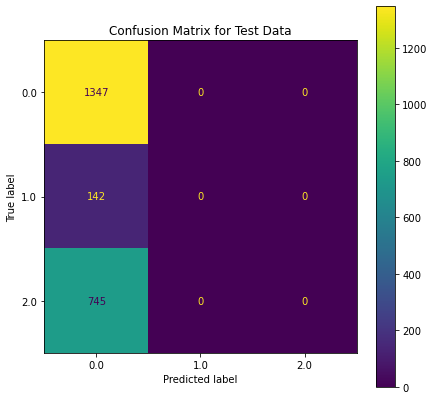

In [43]:
dummy_0 = Mult_Model("Dummy", dummy, tfidf, X_train_tfidf, X_test_tfidf, y_train, y_test)

# MNB

In [44]:
mnb = MultinomialNB()

In [45]:
mnb.fit(X_train_tfidf, y_train)

MultinomialNB()

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.8s finished
C:\Users\rchag\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


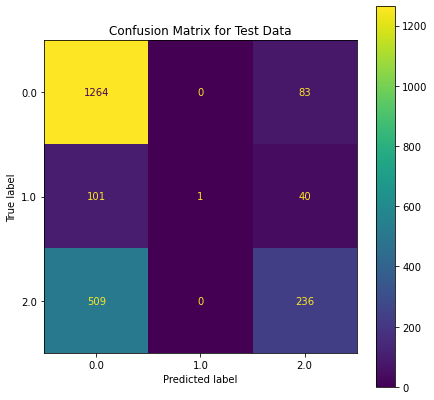

In [46]:
mnb1 = Mult_Model("MultNaiveBayes TF", mnb, tfidf, X_train_tfidf, X_test_tfidf, y_train, y_test)

# MNB Count Vectorized

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.0s finished
C:\Users\rchag\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


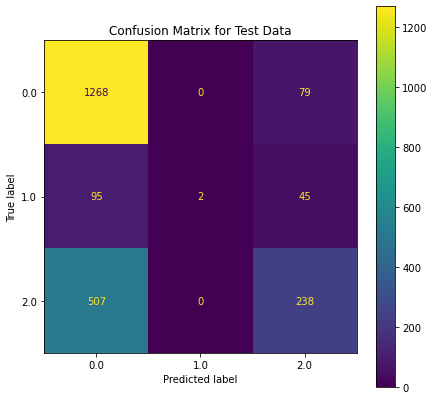

In [47]:
mnb2 = Mult_Model("MultNaiveBayes Vcount", mnb, v_count, X_train_vcount, X_test_vcount, y_train, y_test)

# Smote

In [48]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_tfidf, y_train)

In [49]:
smv = SMOTE(random_state=42)
X_vec, y_vec = smv.fit_resample(X_train_vcount, y_train)

# Random Forest

In [50]:
rndm_tfidf = RandomForestClassifier(random_state=42)
rndm_tfidf.fit(X_res, y_res)

RandomForestClassifier(random_state=42)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   33.5s finished


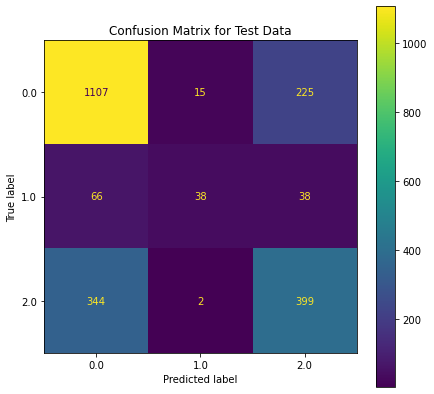

In [51]:
rndm_tfidf1 = Mult_Model("RNDM TF", rndm_tfidf, tfidf, X_train_tfidf, X_test_tfidf, y_train, y_test)

In [52]:
rndm_vec = RandomForestClassifier(random_state=42)
rndm_vec.fit(X_vec, y_vec)

RandomForestClassifier(random_state=42)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   41.2s finished


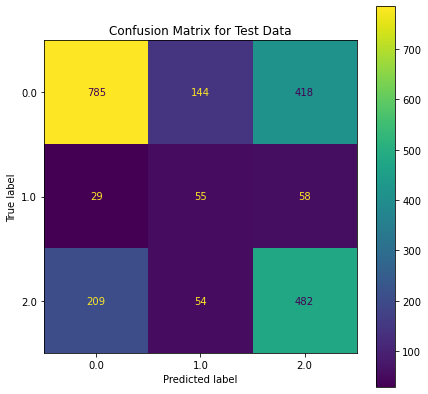

In [53]:
rndm_cvec = Mult_Model("RNDM Vcount", rndm_vec, v_count, X_train_vcount, X_test_vcount, y_train, y_test)

# Logistic Regression

In [54]:
lr = LogisticRegression(random_state=42)

lr.fit(X_train_tfidf, y_train)

C:\Users\rchag\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   15.6s finished


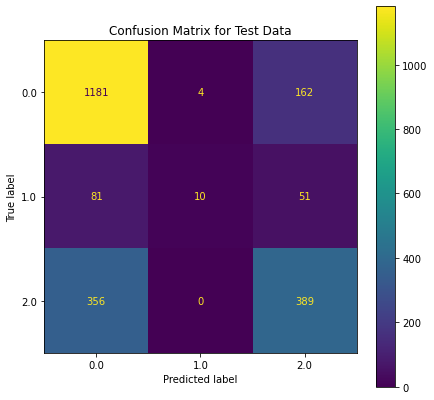

In [55]:
LogReg_tfid = Mult_Model("LogReg TF", lr, tfidf, X_train_tfidf, X_test_tfidf, y_train, y_test)

In [56]:
lr_vec = LogisticRegression(random_state=42).fit(X_train_vcount, y_train)

C:\Users\rchag\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Compare binary classifier with mutliclass classifier on specifics targets

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   17.9s finished


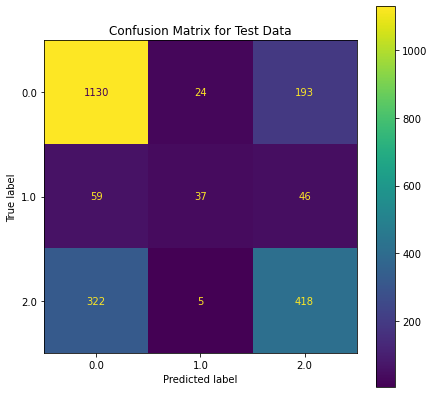

In [64]:
LogReg_vec = Mult_Model("LogReg Vcount", lr_vec, v_count, X_train_vcount, X_test_vcount, y_train, y_test)

In [65]:
Mult_Model.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss
0,Dummy,0.602954,0.200985,0.333333,0.250768,0.846918,0.602954,0.200985,0.333333,0.250768,0.846425
1,MultNaiveBayes TF,0.656668,0.430403,0.406035,0.389400,0.814117,0.671889,0.777292,0.420734,0.408791,0.793396
2,MultNaiveBayes Vcount,0.663086,0.550290,0.488353,0.499264,1.082601,0.675022,0.778511,0.424966,0.415360,1.388420
3,RNDM TF,0.689047,0.668901,0.488866,0.514135,0.786700,0.691137,0.674453,0.541667,0.575332,0.760897
4,RNDM Vcount,0.696508,0.687531,0.508880,0.539974,0.857006,0.591764,0.495958,0.539027,0.502329,1.114178
5,LogReg TF,0.690688,0.696657,0.473886,0.480935,0.672516,0.707252,0.696793,0.489778,0.500804,0.652133
6,LogReg Vcount,0.690539,0.616508,0.532165,0.555402,0.729314,0.674575,0.673428,0.446919,0.457776,1.347976
7,LogReg Vcount,0.690539,0.616508,0.532165,0.555402,0.729314,0.709490,0.648227,0.553513,0.580941,0.692073


# Grid Search

In [59]:
grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'fit_intercept': [True, False],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 300],
    'class_weight': [None, 'balanced']
}

In [60]:
grid_search = GridSearchCV(lr, param_grid=grid, cv = 5, scoring = 'accuracy',n_jobs = -1, verbose=2)

In [61]:
#grid_search.fit(X_train_tfidf, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'class_weight': [None, 'balanced'],
                         'fit_intercept': [True, False],
                         'max_iter': [100, 200, 300], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy', verbose=2)

In [62]:
#grid_search.best_params_

{'C': 10,
 'class_weight': None,
 'fit_intercept': True,
 'max_iter': 100,
 'penalty': 'l2',
 'solver': 'saga'}

In [66]:
lr_gs = LogisticRegression(C= 10,
 class_weight= None,
 fit_intercept = True,
 max_iter= 100,
 penalty= 'l2',
 solver= 'saga',
 random_state = 42).fit(X_train_tfidf, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  2.3min finished


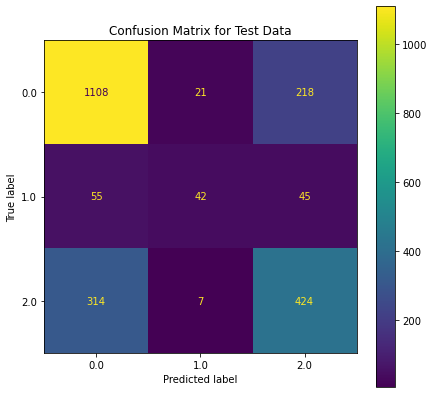

In [67]:
LogReg_tfidgs = Mult_Model("LogReg tfid gs", lr_gs, tfidf, X_train_tfidf, X_test_tfidf, y_train, y_test)

# KNN

In [68]:
kntfidf = KNeighborsClassifier()

kntfidf.fit(X_train_tfidf, y_train)

KNeighborsClassifier()

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    4.7s finished


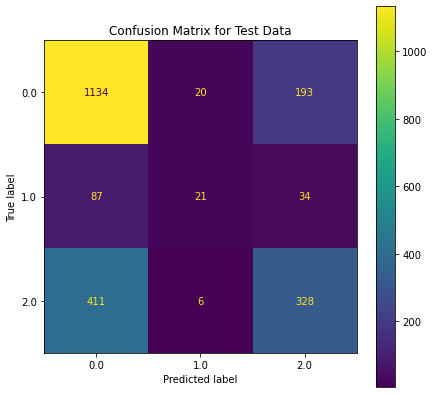

In [69]:
knn = Mult_Model("KNN TF", kntfidf, tfidf, X_train_tfidf, X_test_tfidf, y_train, y_test)

In [70]:
Mult_Model.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss
0,Dummy,0.602954,0.200985,0.333333,0.250768,0.846918,0.602954,0.200985,0.333333,0.250768,0.846425
1,MultNaiveBayes TF,0.656668,0.430403,0.406035,0.389400,0.814117,0.671889,0.777292,0.420734,0.408791,0.793396
2,MultNaiveBayes Vcount,0.663086,0.550290,0.488353,0.499264,1.082601,0.675022,0.778511,0.424966,0.415360,1.388420
3,RNDM TF,0.689047,0.668901,0.488866,0.514135,0.786700,0.691137,0.674453,0.541667,0.575332,0.760897
4,RNDM Vcount,0.696508,0.687531,0.508880,0.539974,0.857006,0.591764,0.495958,0.539027,0.502329,1.114178
5,LogReg TF,0.690688,0.696657,0.473886,0.480935,0.672516,0.707252,0.696793,0.489778,0.500804,0.652133
6,LogReg Vcount,0.690539,0.616508,0.532165,0.555402,0.729314,0.674575,0.673428,0.446919,0.457776,1.347976
7,LogReg Vcount,0.690539,0.616508,0.532165,0.555402,0.729314,0.709490,0.648227,0.553513,0.580941,0.692073
8,LogReg tfid gs,0.692480,0.628559,0.536125,0.560131,0.742310,0.704566,0.655782,0.562490,0.591036,0.713757
9,KNN TF,0.658311,0.594099,0.475143,0.497408,3.337681,0.663832,0.577551,0.476676,0.496056,2.970666


In [71]:
kn_vcount = KNeighborsClassifier().fit(X_train_vcount, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    7.7s finished


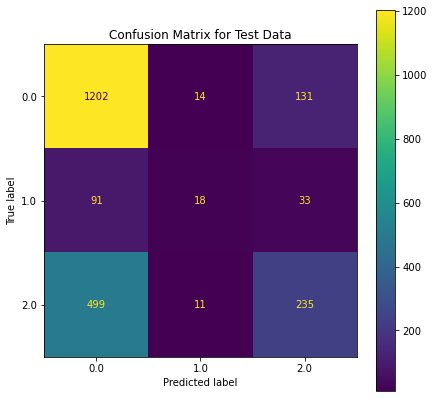

In [72]:
knn = Mult_Model("KNN Vcount", kn_vcount, v_count, X_train_vcount, X_test_vcount, y_train, y_test)

In [73]:
Mult_Model.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss
0,Dummy,0.602954,0.200985,0.333333,0.250768,0.846918,0.602954,0.200985,0.333333,0.250768,0.846425
1,MultNaiveBayes TF,0.656668,0.430403,0.406035,0.389400,0.814117,0.671889,0.777292,0.420734,0.408791,0.793396
2,MultNaiveBayes Vcount,0.663086,0.550290,0.488353,0.499264,1.082601,0.675022,0.778511,0.424966,0.415360,1.388420
3,RNDM TF,0.689047,0.668901,0.488866,0.514135,0.786700,0.691137,0.674453,0.541667,0.575332,0.760897
4,RNDM Vcount,0.696508,0.687531,0.508880,0.539974,0.857006,0.591764,0.495958,0.539027,0.502329,1.114178
5,LogReg TF,0.690688,0.696657,0.473886,0.480935,0.672516,0.707252,0.696793,0.489778,0.500804,0.652133
6,LogReg Vcount,0.690539,0.616508,0.532165,0.555402,0.729314,0.674575,0.673428,0.446919,0.457776,1.347976
7,LogReg Vcount,0.690539,0.616508,0.532165,0.555402,0.729314,0.709490,0.648227,0.553513,0.580941,0.692073
8,LogReg tfid gs,0.692480,0.628559,0.536125,0.560131,0.742310,0.704566,0.655782,0.562490,0.591036,0.713757
9,KNN TF,0.658311,0.594099,0.475143,0.497408,3.337681,0.663832,0.577551,0.476676,0.496056,2.970666


# ADA Boost

In [74]:
ada_tf = AdaBoostClassifier(random_state= 42)
ada_tf.fit(X_train_tfidf, y_train)

AdaBoostClassifier(random_state=42)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   33.7s finished


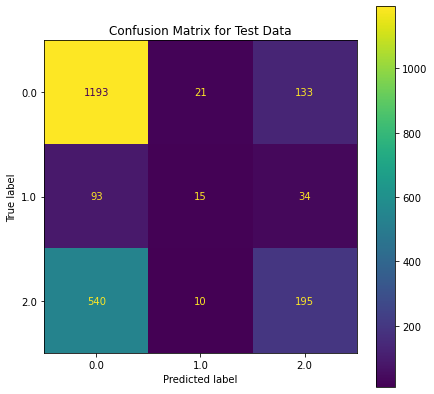

In [75]:
ada_tf = Mult_Model("ADA TF", ada_tf, tfidf, X_train_tfidf, X_test_tfidf, y_train, y_test)

In [76]:
Mult_Model.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss
0,Dummy,0.602954,0.200985,0.333333,0.250768,0.846918,0.602954,0.200985,0.333333,0.250768,0.846425
1,MultNaiveBayes TF,0.656668,0.430403,0.406035,0.389400,0.814117,0.671889,0.777292,0.420734,0.408791,0.793396
2,MultNaiveBayes Vcount,0.663086,0.550290,0.488353,0.499264,1.082601,0.675022,0.778511,0.424966,0.415360,1.388420
3,RNDM TF,0.689047,0.668901,0.488866,0.514135,0.786700,0.691137,0.674453,0.541667,0.575332,0.760897
4,RNDM Vcount,0.696508,0.687531,0.508880,0.539974,0.857006,0.591764,0.495958,0.539027,0.502329,1.114178
5,LogReg TF,0.690688,0.696657,0.473886,0.480935,0.672516,0.707252,0.696793,0.489778,0.500804,0.652133
6,LogReg Vcount,0.690539,0.616508,0.532165,0.555402,0.729314,0.674575,0.673428,0.446919,0.457776,1.347976
7,LogReg Vcount,0.690539,0.616508,0.532165,0.555402,0.729314,0.709490,0.648227,0.553513,0.580941,0.692073
8,LogReg tfid gs,0.692480,0.628559,0.536125,0.560131,0.742310,0.704566,0.655782,0.562490,0.591036,0.713757
9,KNN TF,0.658311,0.594099,0.475143,0.497408,3.337681,0.663832,0.577551,0.476676,0.496056,2.970666


In [77]:
ada_vc = AdaBoostClassifier(random_state= 42)
ada_vc.fit(X_train_vcount, y_train)

AdaBoostClassifier(random_state=42)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   34.4s finished


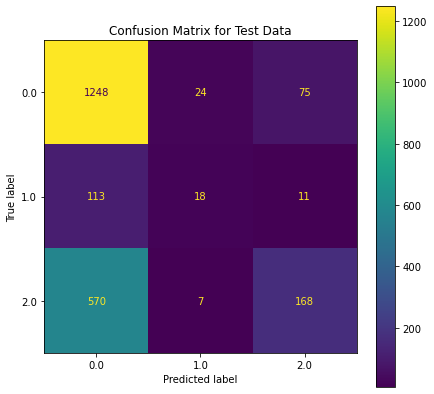

In [78]:
knn = Mult_Model("ADA Vcount", ada_vc, v_count, X_train_vcount, X_test_vcount, y_train, y_test)

In [79]:
Mult_Model.model_df.sort_values(by = ['test_accuracy'], ascending = False).head()

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss
7,LogReg Vcount,0.690539,0.616508,0.532165,0.555402,0.729314,0.709490,0.648227,0.553513,0.580941,0.692073
5,LogReg TF,0.690688,0.696657,0.473886,0.480935,0.672516,0.707252,0.696793,0.489778,0.500804,0.652133
8,LogReg tfid gs,0.692480,0.628559,0.536125,0.560131,0.742310,0.704566,0.655782,0.562490,0.591036,0.713757
3,RNDM TF,0.689047,0.668901,0.488866,0.514135,0.786700,0.691137,0.674453,0.541667,0.575332,0.760897
2,MultNaiveBayes Vcount,0.663086,0.550290,0.488353,0.499264,1.082601,0.675022,0.778511,0.424966,0.415360,1.388420


In [80]:
Mult_Model.model_df.to_csv('data/Mult_Model.csv')

# LAD

In [114]:
from sklearn.datasets import make_multilabel_classification

lda = LatentDirichletAllocation(n_components=3, random_state = 42)

In [115]:
X_train_lda = v_count.fit_transform(X_train['tokens'])

In [116]:
X_test_lda = v_count.fit_transform(X_test['tokens'])

In [117]:
X_train_lda

<6702x6780 sparse matrix of type '<class 'numpy.int64'>'
	with 76795 stored elements in Compressed Sparse Row format>

In [126]:
X_test_lda

<2234x3914 sparse matrix of type '<class 'numpy.int64'>'
	with 25560 stored elements in Compressed Sparse Row format>

In [118]:
lda.fit_transform(X = X_train_lda,y = y_train)

array([[0.03926471, 0.25799062, 0.70274467],
       [0.02384238, 0.02492361, 0.95123401],
       [0.05430032, 0.89380865, 0.05189103],
       ...,
       [0.02719729, 0.94442753, 0.02837519],
       [0.02040927, 0.95724983, 0.0223409 ],
       [0.03689511, 0.79028086, 0.17282403]])

In [119]:
lda.set_output(transform ='pandas')

LatentDirichletAllocation(n_components=3, random_state=42)

In [120]:
X_train_lda_tr = lda.fit_transform(X_train_lda, y = y_train)

In [127]:
X_train_lda_ny = lda.fit_transform(X_train_lda)

In [128]:
X_train_lda_tr.head()


,latentdirichletallocation0,latentdirichletallocation1,latentdirichletallocation2
0,0.039265,0.257991,0.702745
1,0.023842,0.024924,0.951234
2,0.054300,0.893809,0.051891
3,0.020661,0.021297,0.958042
4,0.033279,0.937057,0.029664


In [129]:
X_train_lda_ny.head()

,latentdirichletallocation0,latentdirichletallocation1,latentdirichletallocation2
0,0.039265,0.257991,0.702745
1,0.023842,0.024924,0.951234
2,0.054300,0.893809,0.051891
3,0.020661,0.021297,0.958042
4,0.033279,0.937057,0.029664


In [132]:
#X_test_lda_tr = lda.transform(X_test_lda)

In [105]:
lr_lda = LogisticRegression(random_state=42)

In [107]:
lr_lda.fit(X_train_lda_tr, y_train)

LogisticRegression(random_state=42)

In [130]:
# will look at again tomorrow :D

In [131]:
#lr_lda = Mult_Model('LR LDA', lr_lda, lda, X_train_lda_tr, X_test_lda_tr,y_train, y_test )

# NLTK Sentiment Intensity Analyzer

In [161]:
import nltk
from nltk.sentiment import sentiment_analyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\rchag\AppData\Roaming\nltk_data...


True

In [141]:
df_clean['tokens'] = df_clean['tokens'].str.lower()

In [142]:
df_clean.head()

,target,tokens
0,1.0,i have a 3g iphone after 3 hrs tweeting at rise austin it was dead i need to upgrade plugin stat...
1,2.0,know about awesome ipad iphone app that you ll likely appreciate for its design also they re giv...
2,2.0,can not wait for ipad 2 also they should sale them down at sxsw
3,1.0,i hope this year s festival isn t as crashy as this year s iphone app sxsw
4,2.0,great stuff on fri sxsw marissa mayer google tim o reilly tech books conferences amp matt mullen...


In [149]:
nltk.word_tokenize(df_clean['tokens'][0])

['i',
 'have',
 'a',
 '3g',
 'iphone',
 'after',
 '3',
 'hrs',
 'tweeting',
 'at',
 'rise',
 'austin',
 'it',
 'was',
 'dead',
 'i',
 'need',
 'to',
 'upgrade',
 'plugin',
 'stations',
 'at',
 'sxsw']

In [150]:
df_clean['tokenize'] = [nltk.word_tokenize(i) for i in df_clean['tokens']]

In [152]:
df_clean.head()

,target,tokens,tokenize
0,1.0,i have a 3g iphone after 3 hrs tweeting at rise austin it was dead i need to upgrade plugin stat...,"[i, have, a, 3g, iphone, after, 3, hrs, tweeting, at, rise, austin, it, was, dead, i, need, to, ..."
1,2.0,know about awesome ipad iphone app that you ll likely appreciate for its design also they re giv...,"[know, about, awesome, ipad, iphone, app, that, you, ll, likely, appreciate, for, its, design, a..."
2,2.0,can not wait for ipad 2 also they should sale them down at sxsw,"[can, not, wait, for, ipad, 2, also, they, should, sale, them, down, at, sxsw]"
3,1.0,i hope this year s festival isn t as crashy as this year s iphone app sxsw,"[i, hope, this, year, s, festival, isn, t, as, crashy, as, this, year, s, iphone, app, sxsw]"
4,2.0,great stuff on fri sxsw marissa mayer google tim o reilly tech books conferences amp matt mullen...,"[great, stuff, on, fri, sxsw, marissa, mayer, google, tim, o, reilly, tech, books, conferences, ..."


In [162]:
vader = SentimentIntensityAnalyzer()

In [168]:
vader.polarity_scores(df_clean['tokens'][0])

{'neg': 0.193, 'neu': 0.807, 'pos': 0.0, 'compound': -0.6486}

In [174]:
df_clean['feeling'] = df_clean['tokens'].apply(lambda tokens : 
                                   vader.polarity_scores(tokens))

df_clean.head()

,target,tokens,tokenize,feeling
0,1.0,i have a 3g iphone after 3 hrs tweeting at rise austin it was dead i need to upgrade plugin stat...,"[i, have, a, 3g, iphone, after, 3, hrs, tweeting, at, rise, austin, it, was, dead, i, need, to, ...","{'neg': 0.193, 'neu': 0.807, 'pos': 0.0, 'compound': -0.6486}"
1,2.0,know about awesome ipad iphone app that you ll likely appreciate for its design also they re giv...,"[know, about, awesome, ipad, iphone, app, that, you, ll, likely, appreciate, for, its, design, a...","{'neg': 0.0, 'neu': 0.59, 'pos': 0.41, 'compound': 0.91}"
2,2.0,can not wait for ipad 2 also they should sale them down at sxsw,"[can, not, wait, for, ipad, 2, also, they, should, sale, them, down, at, sxsw]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
3,1.0,i hope this year s festival isn t as crashy as this year s iphone app sxsw,"[i, hope, this, year, s, festival, isn, t, as, crashy, as, this, year, s, iphone, app, sxsw]","{'neg': 0.0, 'neu': 0.643, 'pos': 0.357, 'compound': 0.7269}"
4,2.0,great stuff on fri sxsw marissa mayer google tim o reilly tech books conferences amp matt mullen...,"[great, stuff, on, fri, sxsw, marissa, mayer, google, tim, o, reilly, tech, books, conferences, ...","{'neg': 0.0, 'neu': 0.796, 'pos': 0.204, 'compound': 0.6249}"


In [176]:
df_clean['compound'] = df_clean['feeling'].apply(lambda score_dict : score_dict['compound'])

df_clean.head()

,target,tokens,tokenize,feeling,compound
0,1.0,i have a 3g iphone after 3 hrs tweeting at rise austin it was dead i need to upgrade plugin stat...,"[i, have, a, 3g, iphone, after, 3, hrs, tweeting, at, rise, austin, it, was, dead, i, need, to, ...","{'neg': 0.193, 'neu': 0.807, 'pos': 0.0, 'compound': -0.6486}",-0.6486
1,2.0,know about awesome ipad iphone app that you ll likely appreciate for its design also they re giv...,"[know, about, awesome, ipad, iphone, app, that, you, ll, likely, appreciate, for, its, design, a...","{'neg': 0.0, 'neu': 0.59, 'pos': 0.41, 'compound': 0.91}",0.9100
2,2.0,can not wait for ipad 2 also they should sale them down at sxsw,"[can, not, wait, for, ipad, 2, also, they, should, sale, them, down, at, sxsw]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000
3,1.0,i hope this year s festival isn t as crashy as this year s iphone app sxsw,"[i, hope, this, year, s, festival, isn, t, as, crashy, as, this, year, s, iphone, app, sxsw]","{'neg': 0.0, 'neu': 0.643, 'pos': 0.357, 'compound': 0.7269}",0.7269
4,2.0,great stuff on fri sxsw marissa mayer google tim o reilly tech books conferences amp matt mullen...,"[great, stuff, on, fri, sxsw, marissa, mayer, google, tim, o, reilly, tech, books, conferences, ...","{'neg': 0.0, 'neu': 0.796, 'pos': 0.204, 'compound': 0.6249}",0.6249


In [187]:
df_clean['sentiment'] = df_clean['compound'].apply(lambda c: 2.0 if c>= .1 else 1.0 if c<=.1 else 0.0)

In [188]:
df_clean.head()

,target,tokens,tokenize,feeling,compound,sentiment
0,1.0,i have a 3g iphone after 3 hrs tweeting at rise austin it was dead i need to upgrade plugin stat...,"[i, have, a, 3g, iphone, after, 3, hrs, tweeting, at, rise, austin, it, was, dead, i, need, to, ...","{'neg': 0.193, 'neu': 0.807, 'pos': 0.0, 'compound': -0.6486}",-0.6486,1.0
1,2.0,know about awesome ipad iphone app that you ll likely appreciate for its design also they re giv...,"[know, about, awesome, ipad, iphone, app, that, you, ll, likely, appreciate, for, its, design, a...","{'neg': 0.0, 'neu': 0.59, 'pos': 0.41, 'compound': 0.91}",0.9100,2.0
2,2.0,can not wait for ipad 2 also they should sale them down at sxsw,"[can, not, wait, for, ipad, 2, also, they, should, sale, them, down, at, sxsw]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000,1.0
3,1.0,i hope this year s festival isn t as crashy as this year s iphone app sxsw,"[i, hope, this, year, s, festival, isn, t, as, crashy, as, this, year, s, iphone, app, sxsw]","{'neg': 0.0, 'neu': 0.643, 'pos': 0.357, 'compound': 0.7269}",0.7269,2.0
4,2.0,great stuff on fri sxsw marissa mayer google tim o reilly tech books conferences amp matt mullen...,"[great, stuff, on, fri, sxsw, marissa, mayer, google, tim, o, reilly, tech, books, conferences, ...","{'neg': 0.0, 'neu': 0.796, 'pos': 0.204, 'compound': 0.6249}",0.6249,2.0


In [189]:
accuracy_score(df_clean['target'], df_clean['sentiment'])

0.24496418979409132

In [190]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,brand,tweet_clean,target
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upg...",iPhone,Negative emotion,Apple,I have a 3G iPhone After 3 hrs tweeting at RISE Austin it was dead I need to upgrade Plugin stat...,1.0
1,@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its de...,iPad or iPhone App,Positive emotion,Apple,Know about Awesome iPad iPhone app that you ll likely appreciate for its design Also they re giv...,2.0
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion,Apple,Can not wait for iPad 2 also They should sale them down at SXSW,2.0
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion,Apple,I hope this year s festival isn t as crashy as this year s iPhone app sxsw,1.0
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conference...",Google,Positive emotion,Google,great stuff on Fri SXSW Marissa Mayer Google Tim O Reilly tech books conferences amp Matt Mullen...,2.0


In [195]:
df['feeling'] = df['tweet_clean'].apply(lambda tokens : 
                                   vader.polarity_scores(tokens))

df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,brand,tweet_clean,target,feeling,compound,sentiment
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upg...",iPhone,Negative emotion,Apple,I have a 3G iPhone After 3 hrs tweeting at RISE Austin it was dead I need to upgrade Plugin stat...,1.0,"{'neg': 0.193, 'neu': 0.807, 'pos': 0.0, 'compound': -0.6486}",-0.6800,1.0
1,@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its de...,iPad or iPhone App,Positive emotion,Apple,Know about Awesome iPad iPhone app that you ll likely appreciate for its design Also they re giv...,2.0,"{'neg': 0.0, 'neu': 0.59, 'pos': 0.41, 'compound': 0.91}",0.9100,2.0
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion,Apple,Can not wait for iPad 2 also They should sale them down at SXSW,2.0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000,1.0
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion,Apple,I hope this year s festival isn t as crashy as this year s iPhone app sxsw,1.0,"{'neg': 0.0, 'neu': 0.643, 'pos': 0.357, 'compound': 0.7269}",0.7269,2.0
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conference...",Google,Positive emotion,Google,great stuff on Fri SXSW Marissa Mayer Google Tim O Reilly tech books conferences amp Matt Mullen...,2.0,"{'neg': 0.0, 'neu': 0.796, 'pos': 0.204, 'compound': 0.6249}",0.6249,2.0


In [196]:
df['compound'] = df['feeling'].apply(lambda score_dict : score_dict['compound'])

In [197]:
df['sentiment'] = df['compound'].apply(lambda c: 2.0 if c>= .1 else 1.0 if c<=.1 else 0.0)

In [198]:
accuracy_score(df['target'], df['sentiment'])

0.2455237242614145